## TEST SET
Applying quickly all the transfomations made in the previous notebook. Just run it and continue to NOTEBOOK 3

## TEST SET CLEANING

In [351]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.10f}'.format

### MISSING VALUE VISUALIZATION
import missingno as msno

### DATA PLOTTING
import matplotlib.pyplot as plt
import seaborn as sns

### DATA PREPROCESSING
from functions import *

### IMPUTATION
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

### ENCODING
from sklearn.preprocessing import LabelEncoder

#### Loading data

In [352]:
test = pd.read_csv('../datasets/henry_lab_disk/properties_colombia_test.csv', sep = ',')
test.drop('id', axis=1, inplace=True)
test.rename(columns={'Unnamed: 0':'id'}, inplace=True)
test.set_index('id', inplace=True)

In [353]:
test.shape

(65850, 24)

In [354]:
todrop = ['operation_type', 'currency', 'created_on', 'price_period', 'l1', 'ad_type']
test.drop(todrop, axis=1, inplace=True)
test = trim_all_columns(test)
test['title'] = normalize_column(test, 'title')
test['description'] = normalize_column(test, 'description')
test['title'] = test['title'].str.lower().str.strip()
test['description'] = test['description'].str.lower().str.strip()
pattern = '|'.join(['\n','\r', '\t' ,'\xa0','\u200b',','])
test['title'] = clean_values(test['title'], pattern, value=' ')
test['description'] = clean_values(test['description'], pattern, value=' ')
pattern2 = '|'.join(['_', '[(|)]', '-',':',';'])
test['title'] = clean_values(test['title'], pattern2, regex = True, value=' ')
test['description'] = clean_values(test['description'], pattern2, regex = True, value=' ')
test['title'] = clean_values(test['title'], r"\<.*?\>", regex = True, value=' ')
test['description'] = clean_values(test['description'], pattern2, regex = True, value=' ')
test['title'] = clean_values(test['title'], r"\{.*?\}", regex = True, value=' ')
test['description'] = clean_values(test['description'], pattern2, regex = True, value=' ')
test['title'] = test['title'].str.replace(' +',' ', regex=True)
test['description'] = test['description'].str.replace(' +',' ', regex = True)

test['description'] = test['description'].str.replace('br / ','',regex = False)
test['description'] = test['description'].str.replace('/b','',regex = False)
test['description'] = test['description'].str.replace(' br ','',regex = False)
test['description'] = test['description'].str.replace(' b ','',regex = False)
test['description'] = test['description'].str.replace('&aacute ','a',regex = False)
test['description'] = test['description'].str.replace('&eacute ','e',regex = False)
test['description'] = test['description'].str.replace('&iacute ','i',regex = False)
test['description'] = test['description'].str.replace('&oacute ','o',regex = False)
test['description'] = test['description'].str.replace('&uacute ','u',regex = False)
test['description'] = test['description'].str.replace('&ntilde ','ñ',regex = False)
test['description'] = test['description'].str.replace('ref#\d+','',regex = True)
test['description'] = test['description'].str.replace('!!!','',regex = False)


regex = r"(\d+\.?\d+(?=m2| m2| mts2| metros cuadrados| mts))"
mask1 = test.loc[:,'title'].str.extract(regex, expand = False).notna()
mask2 = test.loc[:,'description'].str.extract(regex, expand = False).notna()
mask_na = test['surface_total'].isna()
test.loc[mask_na & mask1, 'surface_total'] = test.loc[mask_na & mask1, 'title'].str.extract(regex, expand = False)
test.loc[mask_na & mask2, 'surface_total'] = test.loc[mask_na & mask2, 'description'].str.extract(regex, expand = False)

mask1 = test['surface_total'].isna()
mask2 = test['surface_covered'].notna()
test.loc[mask1 & mask2,'surface_total'] = test.loc[mask1 & mask2,'surface_covered']

regex = r"(\d+\.?\d+(?=hectareas| hectareas|hectáreas| hectáreas|hectárea| hectárea|hectare| hectare|has| has))"
indexes = test.loc[:,'description'].str.extract(regex, expand = False).dropna().astype(float).sort_values(ascending = False).index.tolist()
test.loc[indexes, 'surface_total'] = test.loc[indexes,'description'].str.extract(regex, expand = False).dropna().astype(float).mul(10000)

test['surface_total'] = pd.to_numeric(test['surface_total'], errors='coerce')

value = '|'.join(['pileta', 'piscina','natatorio'])
test['pileta'] = test['description'].str.contains(value, regex = True, case = False)
test['pileta'].fillna(False, inplace=True)

value = '|'.join(['vigilancia 24', 'porteria 24', 'seguridad 24', 'vigilancia las 24', 'porteria las 24', 'seguridad las 24'])
test['vigilancia'] = test['description'].str.contains(value, regex = True, case = False)
test['vigilancia'].fillna(False, inplace=True)

value = '|'.join(['patio', 'jardin', 'parque'])
test['patio'] = test['description'].str.contains(value, regex = True, case = False)
test['patio'].fillna(False, inplace=True)

value = '|'.join(['garage', 'garaje', 'cochera', 'parquedero'])
test['garage'] = test['description'].str.contains(value, regex = True, case = False)
test['garage'].fillna(False, inplace=True)

value = '|'.join(['balcon', 'balcn', 'valcon'])
test['balcon'] = test['description'].str.contains(value, regex = True, case = False)
test['balcon'].fillna(False, inplace=True)

value = '|'.join(['cancha'])
test['cancha'] = test['description'].str.contains(value, regex = True, case = False)
test['cancha'].fillna(False, inplace=True)

value = '|'.join(['gimnasio', 'gym', 'gim', 'fitnes'])
test['gimnasio'] = test['description'].str.contains(value, regex = True, case = False)
test['gimnasio'].fillna(False, inplace=True)

value = '|'.join(['sauna', 'solarium', 'ducha turca', 'ducha escocesa'])
test['sauna'] = test['description'].str.contains(value, regex = True, case = False)
test['sauna'].fillna(False, inplace=True)

value = '|'.join(['estren'])
test['a_estrenar'] = test['description'].str.contains(value, regex = True, case = False)
test['a_estrenar'].fillna(False, inplace=True)




regex = r"(\d+(?=bano| bano|banio| banio))"
mask = test.loc[:,'bathrooms'].isna()
test.loc[mask, 'bathrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)

regex = r'(un)|(?=bano| bano|banio| banio| bao|bao)'
mask = test.loc[:,'bathrooms'].isna()
test.loc[mask, 'bathrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bathrooms'] = test['bathrooms'].str.replace('un', '1')


regex = r'(dos)|(?=bano| bano|banio| banio| bao|bao)'
mask = test.loc[:,'bathrooms'].isna()
test.loc[mask, 'bathrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bathrooms'] = test['bathrooms'].str.replace('dos', '2')

regex = r'(tres)|(?=bano| bano|banio| banio| bao|bao)'
mask = test.loc[:,'bathrooms'].isna()
test.loc[mask, 'bathrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bathrooms'] = test['bathrooms'].str.replace('tres', '3')

regex = r'(cuatro)|(?=bano| bano|banio| banio| bao|bao)'
mask = test.loc[:,'bathrooms'].isna()
test.loc[mask, 'bathrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bathrooms'] = test['bathrooms'].str.replace('cuatro', '4')

regex = r'(cinco)|(?=bano| bano|banio| banio| bao|bao)'
mask = test.loc[:,'bathrooms'].isna()
test.loc[mask, 'bathrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bathrooms'] = test['bathrooms'].str.replace('cinco', '5')

regex = r'(seis)|(?=bano| bano|banio| banio| bao|bao)'
mask = test.loc[:,'bathrooms'].isna()
test.loc[mask, 'bathrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bathrooms'] = test['bathrooms'].str.replace('seis', '6')

regex = r'(siete)|(?=bano| bano|banio| banio| bao|bao)'
mask = test.loc[:,'bathrooms'].isna()
test.loc[mask, 'bathrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bathrooms'] = test['bathrooms'].str.replace('siete', '7')

regex = r'(ocho)|(?=bano| bano|banio| banio| bao|bao)'
mask = test.loc[:,'bathrooms'].isna()
test.loc[mask, 'bathrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bathrooms'] = test['bathrooms'].str.replace('ocho', '8')

test['bathrooms'] = pd.to_numeric(test['bathrooms'], errors = 'coerce')
test['bathrooms_cat'] = pd.cut(test['bathrooms'], bins = [0,1,2,3,np.inf], labels = ['0','1','2','3 o mas'])




regex = r'(\d+(?=habitac| habitac |alcob| alcob|cuart| cuart))'
mask = test.loc[:,'bedrooms'].isna()
test.loc[mask, 'bedrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)

regex = r'(una)|(?=habitac| habitac |alcob| alcob|cuart| cuart)'
mask = test.loc[:,'bedrooms'].isna()
test.loc[mask, 'bedrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bedrooms'] = test['bedrooms'].str.replace('una', '1')
test['bedrooms'].isna().value_counts()

regex = r'(un)|(?=habitac| habitac |alcob| alcob|cuart| cuart)'
mask = test.loc[:,'bedrooms'].isna()
test.loc[mask, 'bedrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bedrooms'] = test['bedrooms'].str.replace('un', '1')
test['bedrooms'].isna().value_counts()

regex = r'(dos)|(?=habitac| habitac |alcob| alcob|cuart| cuart)'
mask = test.loc[:,'bedrooms'].isna()
test.loc[mask, 'bedrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bedrooms'] = test['bedrooms'].str.replace('dos', '2')
test['bedrooms'].isna().value_counts()

regex = r'(tres)|(?=habitac| habitac |alcob| alcob|cuart| cuart)'
mask = test.loc[:,'bedrooms'].isna()
test.loc[mask, 'bedrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bedrooms'] = test['bedrooms'].str.replace('tres', '3')
test['bedrooms'].isna().value_counts()

regex = r'(cuatro)|(?=habitac| habitac |alcob| alcob|cuart| cuart)'
mask = test.loc[:,'bedrooms'].isna()
test.loc[mask, 'bedrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bedrooms'] = test['bedrooms'].str.replace('cuatro', '4')
test['bedrooms'].isna().value_counts()

regex = r'(cinco)|(?=habitac| habitac |alcob| alcob|cuart| cuart)'
mask = test.loc[:,'bedrooms'].isna()
test.loc[mask, 'bedrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bedrooms'] = test['bedrooms'].str.replace('cinco', '5')
test['bedrooms'].isna().value_counts()

regex = r'(seis)|(?=habitac| habitac |alcob| alcob|cuart| cuart)'
mask = test.loc[:,'bedrooms'].isna()
test.loc[mask, 'bedrooms'] = test.loc[mask, 'description'].str.extract(regex, expand = False)
test['bedrooms'] = test['bedrooms'].str.replace('seis', '6')
test['bedrooms'].isna().value_counts()


test['bedrooms'] = pd.to_numeric(test['bedrooms'], errors = 'coerce')
test['bedrooms_cat'] = pd.cut(test['bedrooms'], bins = [0,1,2,3,np.inf], labels = ['0','1','2','3 o mas'])

test['description'].fillna(' ', inplace=True)

<>:31: DeprecationWarning: invalid escape sequence \d
<>:31: DeprecationWarning: invalid escape sequence \d
/tmp/ipykernel_286/2543621569.py:31: DeprecationWarning: invalid escape sequence \d
  test['description'] = test['description'].str.replace('ref#\d+','',regex = True)


In [355]:
test.shape

(65850, 29)

In [356]:
test.drop('geometry', axis = 1, inplace = True)
mask_l2 = test.loc[:,'l2'].notna()
mask_l3 = test.loc[:,'l3'].notna()
mask_l4 = test.loc[:,'l4'].notna()
mask_l5 = test.loc[:,'l5'].notna()
mask_l6 = test.loc[:,'l6'].notna()
mask_lat = test.loc[:,'lat'].isna()
mask_lon = test.loc[:,'lon'].isna()

locations_gps = pd.read_csv('./data/gps/locations_all_df_google.csv')
test['full_location'] = test.agg(lambda x: f"{x['l6']},{x['l5']},{x['l4']},{x['l3']},{x['l2']},Colombia", axis=1)
test['full_location'] = test['full_location'].str.replace('nan,','')
test = test.merge(locations_gps, how='left',  left_on='full_location', right_on='l_all', suffixes=('', '_new'))
test['lat'] = np.where(test['lat'].isna(), test['lat_new'], test['lat'])
test['lon'] = np.where(test['lon'].isna(), test['lon_new'], test['lon'])
todrop = ['full_location', 'l_all', 'lat_new', 'lon_new']
test.drop(todrop, axis = 1, inplace = True)

test['end_date'] = pd.to_datetime(test['end_date'], errors = 'coerce')
test['start_date'] = pd.to_datetime(test['start_date'], errors = 'coerce')
test['days_published'] = test['end_date'] - test['start_date']
test['days_published'] = test['days_published'].dt.days
test.drop('end_date', axis = 1, inplace = True)


In [357]:
test.shape

(65850, 28)

In [358]:
test_nodeleted = test.copy()
test_nodeleted.to_csv('./data/test_nodeleted.csv')
todrop = ['bedrooms', 'rooms', 'bathrooms','surface_covered', 'l4', 'l5', 'l6', 'title', 'description']#,
 #'bathrooms_cat',
# 'bedrooms_cat']

test_before_drop = test.copy()
test.drop(todrop, axis = 1, inplace = True)

In [359]:
test['l2'].fillna('NA', inplace = True)
test['l3'].fillna('NA', inplace = True)
test['property_type'].fillna(test['property_type'].mode()[0], inplace = True)

cat_encode = [
 'pileta',
 'vigilancia',
 'patio',
 'garage',
 'balcon',
 'cancha',
 'gimnasio',
 'sauna',
 'a_estrenar',
'bathrooms_cat',
'bedrooms_cat']

le = LabelEncoder()
test[cat_encode] = test[cat_encode].apply(lambda x: le.fit_transform(x))

test['surface_total'] = test['surface_total'].astype(float)
test['start_date'].fillna(test['start_date'].mode()[0], inplace = True)

lista_na = test.loc[:, test.isna().any()].columns.tolist()
test_mice = test.filter(lista_na, axis=1).copy()
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(test_mice), columns=test_mice.columns)
test[df_mice_imputed.columns.tolist()] = df_mice_imputed

In [360]:
test.shape

(65850, 19)

In [361]:
test.to_csv('./data/cleaned/test_cleaned_imputed.csv', index = True)

In [362]:
from pandas_profiling import ProfileReport
profile = ProfileReport(test)
profile.to_file("reporte_test.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/missingno/missingno.py:73: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## MINIMAL EXPLORATORY ANALYSIS

## CORRELATION PLOT

<AxesSubplot:>

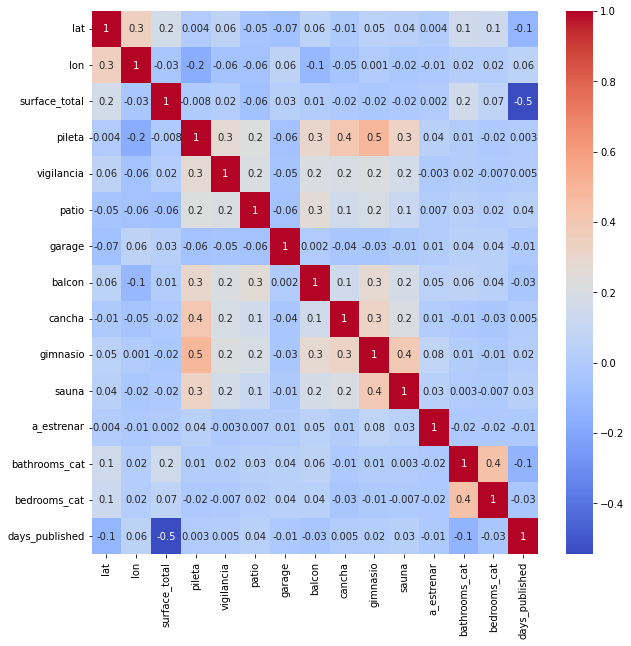

In [363]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(test.corr(method='spearman'), annot=True, fmt='.1g', cmap='coolwarm')

In [364]:
test.describe()

,lat,lon,surface_total,pileta,vigilancia,patio,garage,balcon,cancha,gimnasio,sauna,a_estrenar,bathrooms_cat,bedrooms_cat,days_published
count,65850.0000000000,65850.0000000000,65850.0000000000,65850.0000000000,65850.0000000000,65850.0000000000,65850.0000000000,65850.0000000000,65850.0000000000,65850.0000000000,65850.0000000000,65850.0000000000,65850.0000000000,65850.0000000000,65850.0000000000
mean,5.8286446381,-75.1157078198,13670917.1665121969,0.2389217920,0.1429612756,0.6040698557,0.1582232346,0.2790888383,0.1097342445,0.1514806378,0.0602277904,0.0464236902,2.5588610478,1.6405618831,41.3513433300
std,2.0989175864,1.0224810692,1161132091.4183301926,0.4264281073,0.3500360124,0.4890532662,0.3649529631,0.4485546946,0.3125605920,0.3585194641,0.2379102000,0.2104024797,1.5931558855,1.6523800261,60.7247213479
min,-4.2031650000,-81.7050520000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
25%,4.6458253750,-75.5963845000,220.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,0.0000000000,1.0000000000
50%,5.0779873000,-75.5248435950,13670917.1664668303,0.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,4.0000000000,1.0000000000,15.0000000000
75%,6.2476376000,-74.1571576000,13670917.1666551046,0.0000000000,0.0000000000,1.0000000000,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,4.0000000000,4.0000000000,61.0000000000
max,13.3387613000,-67.9243361000,297965560000.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,4.0000000000,4.0000000000,431.0000000000


In [365]:
cat = ['property_type','pileta','vigilancia','patio','garage','balcon','cancha','gimnasio','sauna','a_estrenar']#,'bathrooms_cat','bedrooms_cat']

subset = test.drop(['l2','l3','start_date','lat','lon'], axis=1)

In [366]:
from tableone import TableOne, load_dataset
#https://tableone.readthedocs.io/en/latest/quickstart.html

mytable = TableOne(subset, dip_test=True, normal_test=True, tukey_test=True, categorical = cat)

mytable.tableone

Missing                    Overall
n                                                                      65850
surface_total, mean (SD)                        0  13670917.2 (1161132091.4)
property_type, n (%)      Apartamento           0               33524 (50.9)
                          Casa                                  20084 (30.5)
                          Finca                                    377 (0.6)
                          Local comercial                          434 (0.7)
                          Lote                                    5704 (8.7)
                          Oficina                                  348 (0.5)
                          Otro                                    5372 (8.2)
                          Parqueadero                                7 (0.0)
pileta, n (%)             0                     0               50117 (76.1)
                          1                                     15733 (23.9)
vigilancia, n (%)         0                     0               56436 (85.7)
                          1                                      9414 (14.3)
patio, n (%)              0                     0               26072 (39.6)
                          1                                     39778 (60.4)
garage, n (%)             0                     0               55431 (84.2)
                          1                                     10419 (15.8)
balcon, n (%)             0                     0               47472 (72.1)
                          1                                     18378 (27.9)
cancha, n (%)             0                     0               58624 (89.0)
                          1                                      7226 (11.0)
gimnasio, n (%)           0                     0               55875 (84.9)
                          1                                      9975 (15.1)
sauna, n (%)              0                     0               61884 (94.0)
                          1                                       3966 (6.0)
a_estrenar, n (%)         0                     0               62793 (95.4)
                          1                                       3057 (4.6)
bathrooms_cat, mean (SD)                        0                  2.6 (1.6)
bedrooms_cat, mean (SD)                         0                  1.6 (1.7)
days_published, mean (SD)                       0                41.4 (60.7)